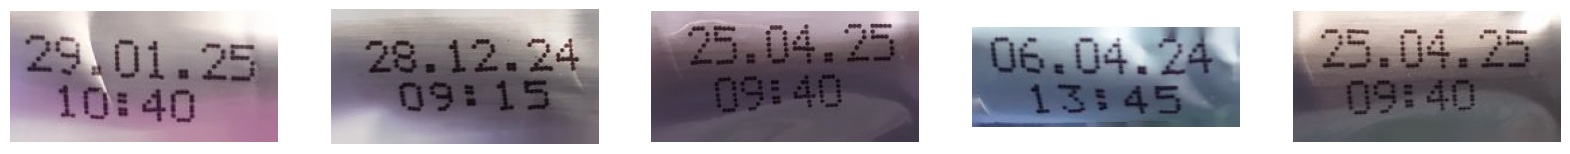

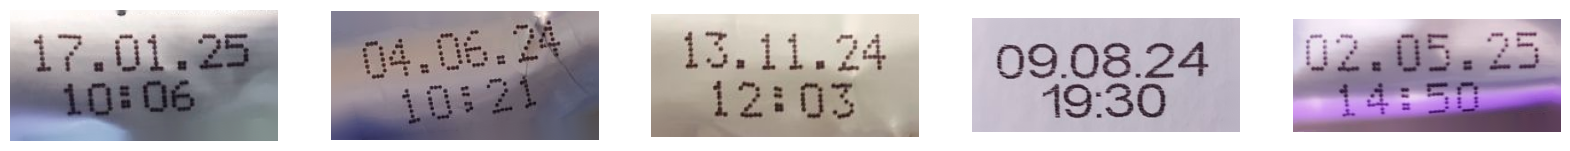

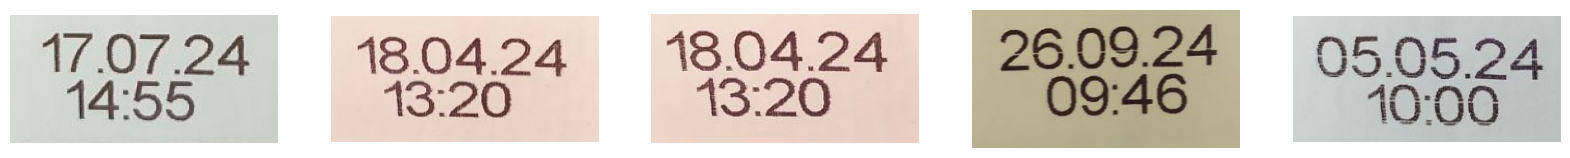

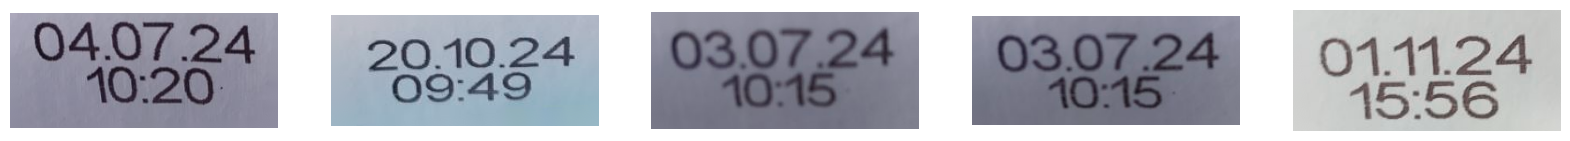

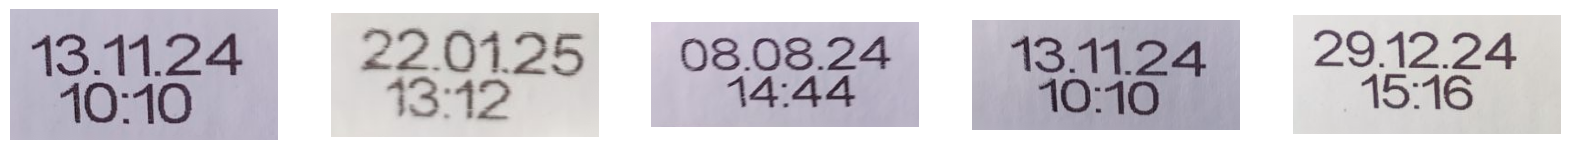

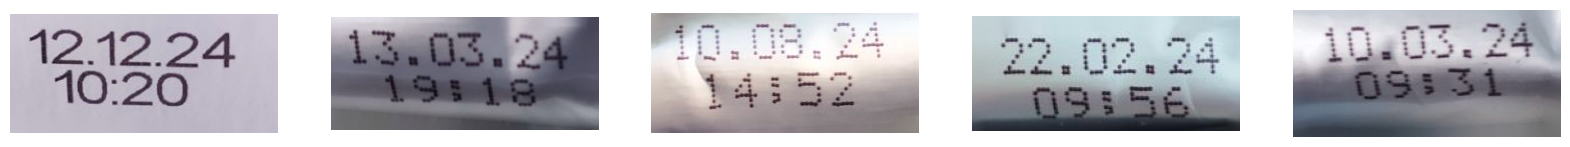

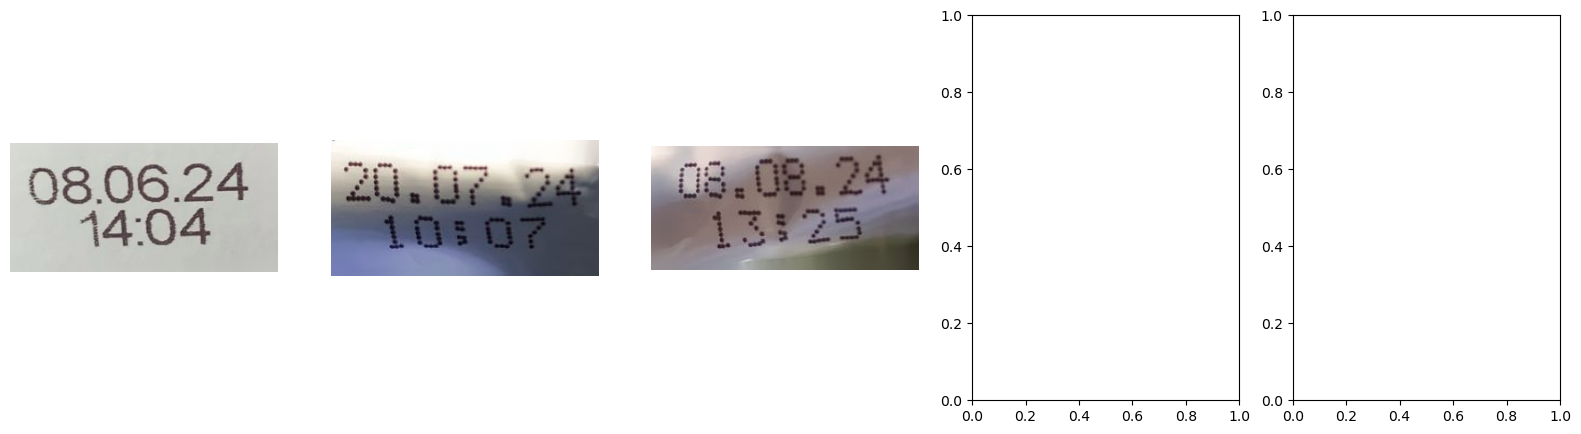

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def fill_black_corners(image, threshold=5):
    # Create a mask where all channels are exactly zero
    mask = np.all(image <= threshold, axis=-1)
    
    # Use inpainting to fill in the black areas
    inpainted_image = cv2.inpaint(image, mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
    
    return inpainted_image

def enhance_text(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel_size = 3
    max_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    alpha = .8   # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)

    bilateral_filtered_image = cv2.bilateralFilter(gray_image, 5, 175, 175)
    more_denoised = cv2.fastNlMeansDenoising(bilateral_filtered_image, None, 13, 7, 21)

    contrast = cv2.convertScaleAbs(more_denoised, alpha=alpha, beta=beta)

    # Apply adaptive thresholding for better text visibility
    thresh = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 2)
    return thresh


def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert to RGB
    filled_image = fill_black_corners(image)

    # Enhance text for better extraction
    # text_image = enhance_text(filled_image)

    # Display the results
    return filled_image


# Path to the folder containing images
photos_path = "./data/soyjoy_cropped"

# List all files in the directory

# Process each photo if it ends with .png
count = 0
show_per_row = 5
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
plastic_images = []
box_images = []
for photo_file in photo_files:
    if photo_file.endswith(".png"):
        photo_path = os.path.join(photos_path, photo_file)
        res = process_image(photo_path)
        if photo_file.split("_")[-2] == "2":
            box_images.append(res)
        else:
            plastic_images.append(res)
        if count % show_per_row == 0:
            fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
        axs[count % show_per_row].imshow(res, cmap='gray')
        axs[count % show_per_row].axis('off')
        count += 1
        if count % show_per_row == 0:
            plt.show()

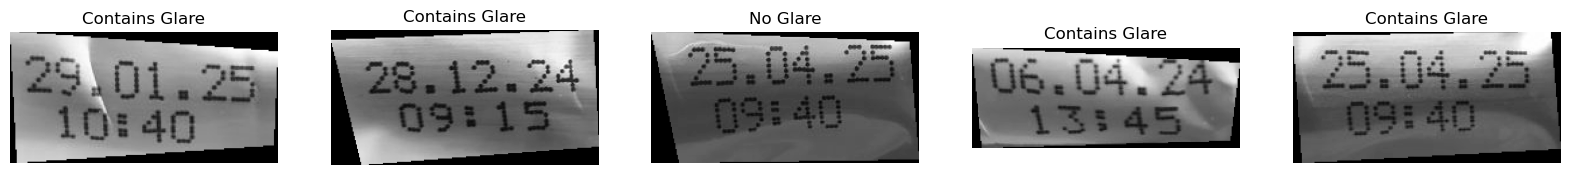

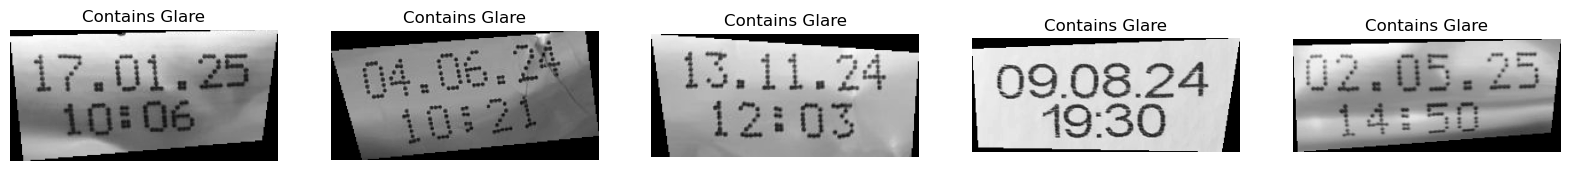

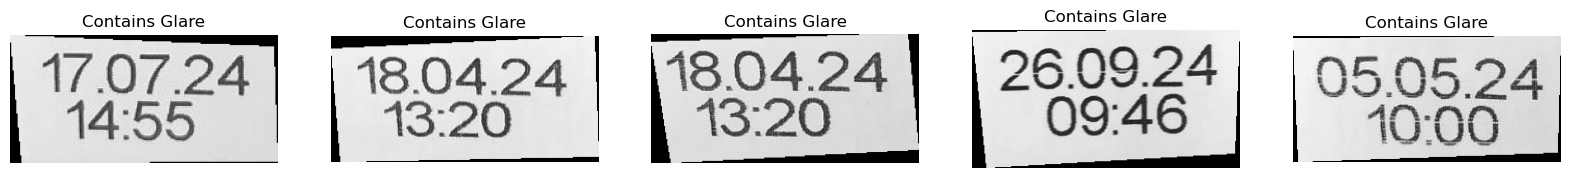

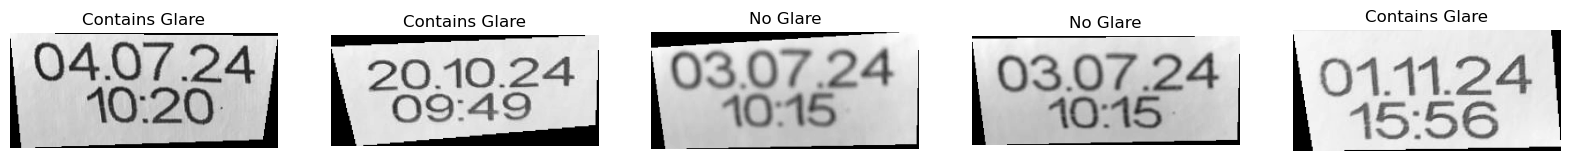

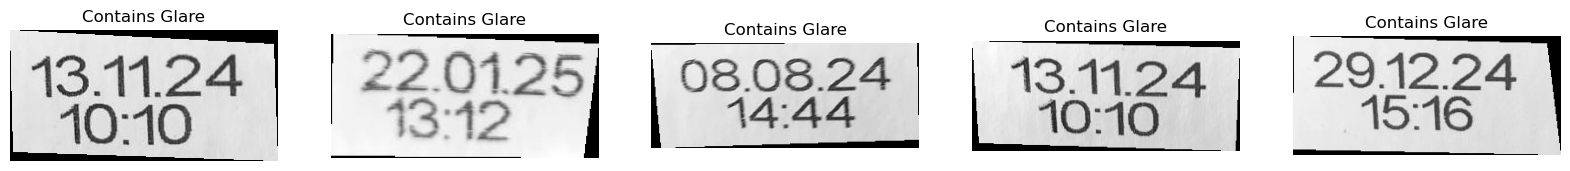

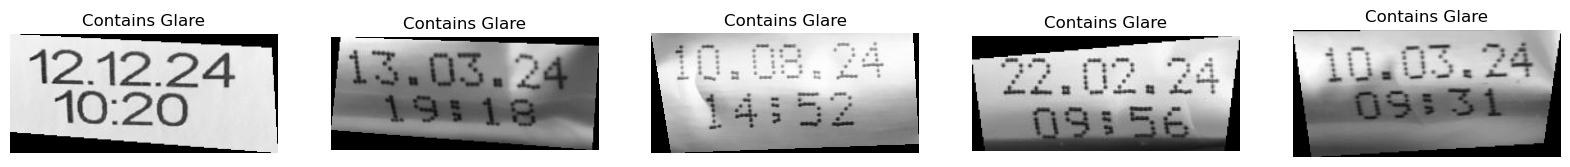

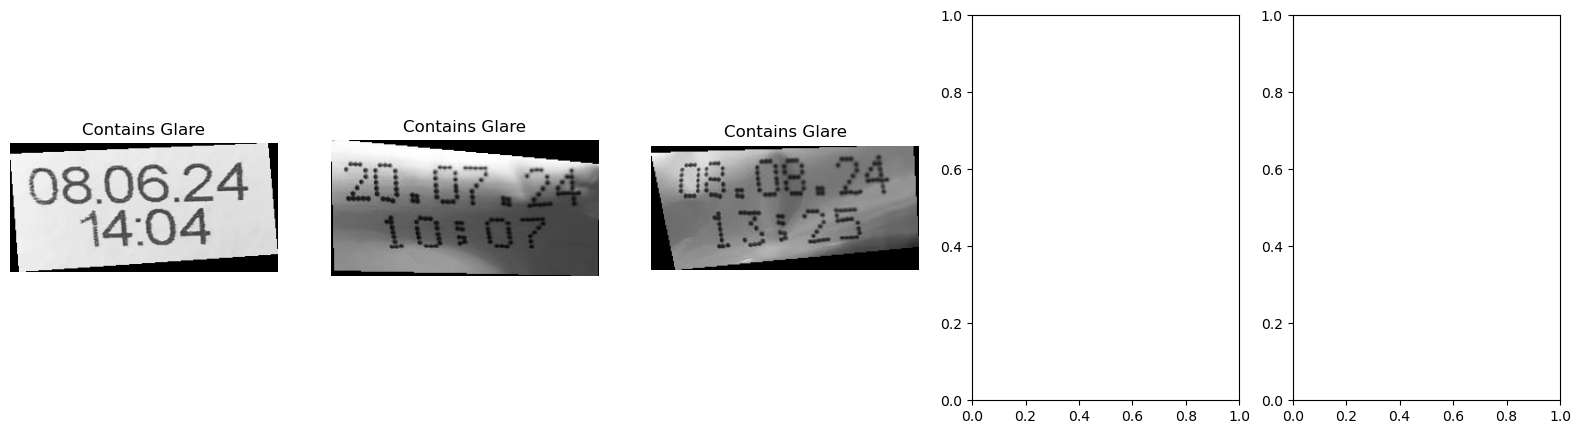

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define glare detection function
def calculate_glare_metrics(image):
    # Calculate mean and variance of pixel intensities
    mean_intensity = np.mean(image)
    variance_intensity = np.var(image)
    
    # Calculate the percentage of bright pixels (indicative of glare)
    bright_pixel_count = np.sum(image > 200)  # Pixels with high intensity (greater than 200)
    bright_pixel_ratio = bright_pixel_count / (image.shape[0] * image.shape[1])
    
    return mean_intensity, variance_intensity, bright_pixel_ratio

def determine_glare(image):
    mean_intensity, variance_intensity, bright_pixel_ratio = calculate_glare_metrics(image)
    
    # Define thresholds to classify as glare or no glare
    mean_threshold = 180  # Example threshold for mean intensity
    variance_threshold = 2500  # Example threshold for intensity variance
    bright_pixel_ratio_threshold = 0.1  # Example threshold for bright pixel ratio (10%)
    
    # Determine if there is glare
    if mean_intensity > mean_threshold or variance_intensity > variance_threshold or bright_pixel_ratio > bright_pixel_ratio_threshold:
        return "Contains Glare"
    else:
        return "No Glare"

# Your previous code with glare detection added to the title of each photo
count = 0
show_per_row = 5
photos_path = "./data/soyjoy_cropped"  # Replace with your actual path
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
plastic_images = []
box_images = []

for photo_file in photo_files:
    if photo_file.endswith(".png"):
        photo_path = os.path.join(photos_path, photo_file)
        
        # Load and process image
        image = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
        processed_image = image  # Assuming `process_image` is used here, modify as needed
        glare_label = determine_glare(processed_image)  # Determine if the image has glare

        # Append image based on label (for organization purposes)
        if photo_file.split("_")[-2] == "2":
            box_images.append(processed_image)
        else:
            plastic_images.append(processed_image)

        # Plot the image and set title based on glare detection
        if count % show_per_row == 0:
            fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))

        axs[count % show_per_row].imshow(processed_image, cmap='gray')
        axs[count % show_per_row].axis('off')
        axs[count % show_per_row].title.set_text(glare_label)  # Set the title as either "Contains Glare" or "No Glare"

        count += 1

        # Show the row of images after reaching the set limit
        if count % show_per_row == 0:
            plt.show()

# Show the remaining images if any
if count % show_per_row != 0:
    plt.show()


In [6]:
import easyocr
count = 0
show_per_row = 5
reader = easyocr.Reader(['en'])

def new_preproc(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return thresh
  
for image in box_images:
  res = new_preproc(image)
  text = reader.readtext(res,detail=0)
  if count % show_per_row == 0:
    fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
  axs[count % show_per_row].title.set_text(text)
  axs[count % show_per_row].imshow(res, cmap='gray')
  axs[count % show_per_row].axis('off')
  count += 1
  if count % show_per_row == 0:
      plt.show()
    
    

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [7]:
import easyocr

show_per_row = 3
reader = easyocr.Reader(['en'])
def new_preproc(image):
    stages = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 2)
    stages.append(gray)
    # remove glare using contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    stages.append(gray)
    
    # adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 9)
    stages.append(thresh)
    return stages    
    
for image in plastic_images:
  res = new_preproc(image)
  count = 0
  for stage in res:
      text = reader.readtext(stage,detail=0)
      if count % show_per_row == 0:
          fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
      axs[count % show_per_row].title.set_text(text)
      axs[count % show_per_row].imshow(stage, cmap='gray')
      axs[count % show_per_row].axis('off')
      
      count += 1
      if count % show_per_row == 0:
          plt.show()
    

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [8]:
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]
for photo_file in photo_files:
    if photo_file.endswith(".png"):
      path = os.path.join(photos_path, photo_file)
      res = process_image(path)
      # save to ./data/more_cap_preprocessed
      cv2.imwrite(f"./data/more_cap_preprocessed/{photo_file}", res)
      print(f"Saved {photo_file}")
print("Done")

Saved 6267247567616197401_1_1.png
Saved 6267247567616197402_1_1.png
Saved 6267247567616197403_1_1.png
Saved 6267247567616197404_1_1.png
Saved 6267247567616197405_1_1.png
Saved 6267247567616197406_1_1.png
Saved 6267247567616197407_1_1.png
Saved 6267247567616197408_1_1.png
Saved 6267247567616197409_2_1.png
Saved 6267247567616197410_1_1.png
Saved 6267247567616197411_2_1.png
Saved 6267247567616197412_2_1.png
Saved 6267247567616197413_2_1.png
Saved 6267247567616197414_2_1.png
Saved 6267247567616197415_2_1.png
Saved 6267247567616197416_2_1.png
Saved 6267247567616197417_2_1.png
Saved 6267247567616197418_2_1.png
Saved 6267247567616197420_2_1.png
Saved 6267247567616197517_2_1.png
Saved 6267247567616197518_2_1.png
Saved 6267247567616197519_2_1.png
Saved 6267247567616197520_2_1.png
Saved 6267247567616197521_2_1.png
Saved 6267247567616197522_2_1.png
Saved 6267247567616197523_2_1.png
Saved 6267247567616197524_1_1.png
Saved 6267247567616197525_1_1.png
Saved 6267247567616197526_1_1.png
Saved 62672475

In [56]:

import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

def localize_image():
    # Load YOLOv8 model
    model = YOLO('./runs/detect/combined_final_lot_no/weights/best.pt')  # Replace with your model path

    # Directory containing JPEG images
    image_folder = './data/soyjoy_raw'

    # Create an output folder if it doesn't exist
    # os.makedirs(output_folder, exist_ok=True)
    count = 0
    show_per_row = 5
    cropped_images = []
    # Iterate over all JPEG files in the directory
    for filename in os.listdir(image_folder):
        if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
            # Construct full file path
            file_path = os.path.join(image_folder, filename)

            # Read image
            image = cv2.imread(file_path)
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            fresh_image = rgb_image.copy()
            if image is None:
                print(f"Error reading image {file_path}")
                continue

            # Perform inference
            results = model(image)

            # Render results on the image
            annotated_image = results[0].plot()  # Adjust according to YOLOv8 results format
            bbox_data = []
            cropped_image = []
            for r in results:
                boxes = r.boxes
                leftest = 0
                for box in boxes:
                    b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
                    c = box.cls  # get class index
                    confidences = box.conf  # get confidence
                    bbox_data.append((b, model.names[int(c)], confidences))
            for bbox in bbox_data:
                cropped_image = fresh_image[
                    int(bbox[0][1]) : int(bbox[0][3]), int(bbox[0][0]) : int(bbox[0][2])
                ]
                # if count % show_per_row == 0:
                #     fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
                # axs[count % show_per_row].imshow(cropped_image)
                # axs[count % show_per_row].axis('off')
                # count += 1
                # if count % show_per_row == 0:
                #     plt.show()
                
                cropped_image = cv2.resize(cropped_image, (250,100))
                cropped_images.append(cropped_image)
                # standardize image size into 100 x 250
                
    return cropped_images
            
            
            
localize_image()
print("Processing complete.")


0: 640x320 1 lot_no, 103.6ms
Speed: 4.4ms preprocess, 103.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 99.3ms
Speed: 3.7ms preprocess, 99.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 171.3ms
Speed: 3.6ms preprocess, 171.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 198.2ms
Speed: 23.0ms preprocess, 198.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 151.3ms
Speed: 6.6ms preprocess, 151.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 121.6ms
Speed: 5.9ms preprocess, 121.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 116.8ms
Speed: 3.8ms preprocess, 116.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 105.5ms
Speed: 4.4ms preprocess, 105.5ms inference, 3.3ms postprocess per image at 


0: 640x320 1 lot_no, 77.1ms
Speed: 5.1ms preprocess, 77.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 77.7ms
Speed: 3.0ms preprocess, 77.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 105.8ms
Speed: 2.3ms preprocess, 105.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 76.3ms
Speed: 2.5ms preprocess, 76.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 71.8ms
Speed: 2.3ms preprocess, 71.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 79.9ms
Speed: 2.0ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 94.9ms
Speed: 4.2ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 lot_no, 90.2ms
Speed: 3.4ms preprocess, 90.2ms inference, 1.5ms postprocess per image at shape (1, 3, 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


CROPPED IMAGE =>  42
--------------------
IMAGE INDEX  0
Top Text: 29.01.25
Bottom Text: 10.40
--------------------
--------------------
IMAGE INDEX  1
Top Text: 28.12.24
Bottom Text: 09.15
--------------------
--------------------
IMAGE INDEX  2
Top Text: 25.04.25
Bottom Text: 09.40
--------------------
--------------------
IMAGE INDEX  3
Top Text: 06.04.24
Bottom Text: 13.45
--------------------
--------------------
IMAGE INDEX  4
Top Text: 25.04.25
Bottom Text: 09.40
--------------------


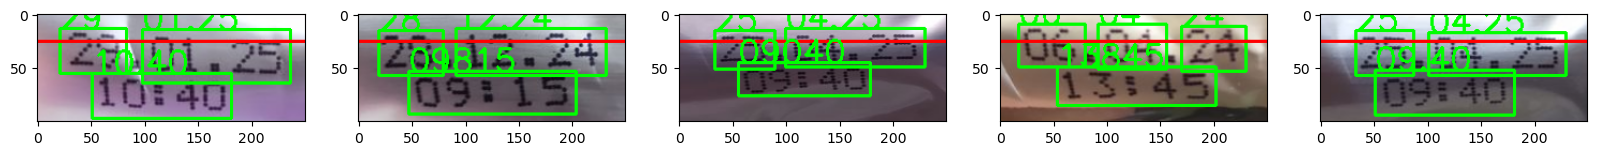

--------------------
IMAGE INDEX  5
Top Text: 17.01.25
Bottom Text: 10.06
--------------------
--------------------
IMAGE INDEX  6
Top Text: 04.06.24
Bottom Text: 10.21
--------------------
--------------------
IMAGE INDEX  7
Top Text: 13.11.24
Bottom Text: 12.03
--------------------
--------------------
IMAGE INDEX  8
Top Text: 09.08.24
Bottom Text: 19.30
--------------------
--------------------
IMAGE INDEX  9
Top Text: Lo.Ae.09.59
Bottom Text: 
--------------------


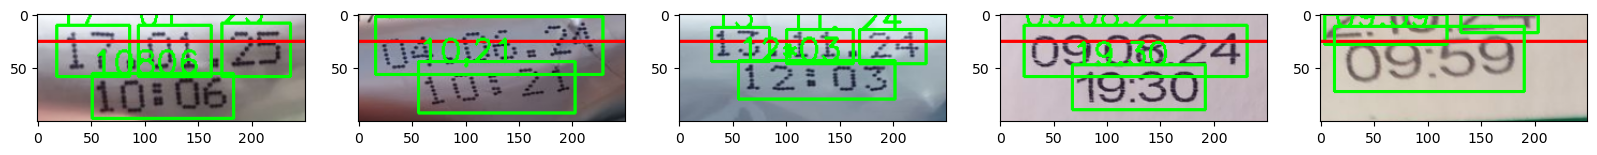

--------------------
IMAGE INDEX  10
Top Text: 02.05.25
Bottom Text: 14.50
--------------------
--------------------
IMAGE INDEX  11
Top Text: 17.07.24
Bottom Text: 14.55
--------------------
--------------------
IMAGE INDEX  12
Top Text: 20.07.24
Bottom Text: 12.11
--------------------
--------------------
IMAGE INDEX  13
Top Text: 18.04.24
Bottom Text: 13.20
--------------------
--------------------
IMAGE INDEX  14
Top Text: 18.04.24
Bottom Text: 13.20
--------------------


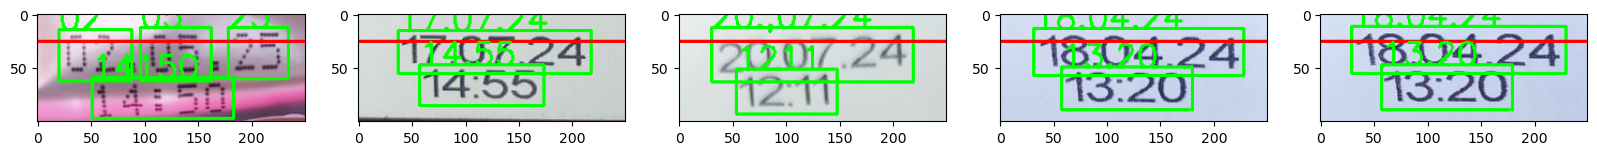

--------------------
IMAGE INDEX  15
Top Text: 26.09.24
Bottom Text: 09.46
--------------------
--------------------
IMAGE INDEX  16
Top Text: 05.05.24
Bottom Text: 10.00
--------------------
--------------------
IMAGE INDEX  17
Top Text: 11.13
Bottom Text: 
--------------------
--------------------
IMAGE INDEX  18
Top Text: 04.07.24
Bottom Text: 10.20
--------------------
--------------------
IMAGE INDEX  19
Top Text: 20.10.24
Bottom Text: 09.49
--------------------


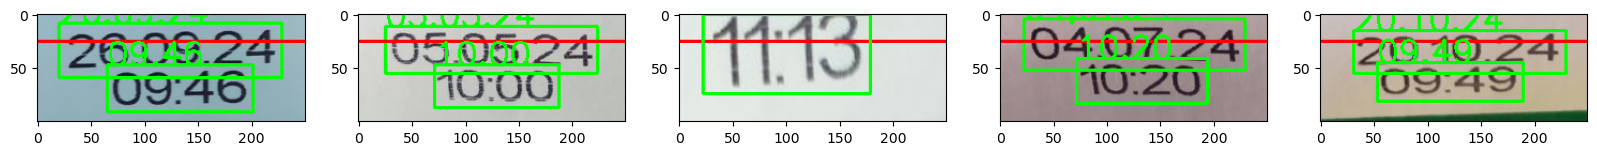

--------------------
IMAGE INDEX  20
Top Text: 03.07.24
Bottom Text: 12.22
--------------------
--------------------
IMAGE INDEX  21
Top Text: 03.07.24
Bottom Text: 70.15
--------------------
--------------------
IMAGE INDEX  22
Top Text: 03.07.24
Bottom Text: IG.26.19.0o
--------------------
--------------------
IMAGE INDEX  23
Top Text: 03.07.24
Bottom Text: 10.15
--------------------
--------------------
IMAGE INDEX  24
Top Text: 03.07.24.22
Bottom Text: 41.25
--------------------


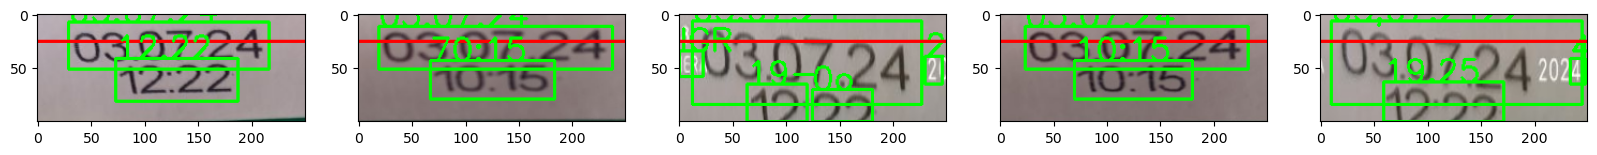

--------------------
IMAGE INDEX  25
Top Text: 01.11.24
Bottom Text: 15.56
--------------------
--------------------
IMAGE INDEX  26
Top Text: 
Bottom Text: 
--------------------
--------------------
IMAGE INDEX  27
Top Text: 13.11.24
Bottom Text: 10.10
--------------------
--------------------
IMAGE INDEX  28
Top Text: 22.01.25
Bottom Text: 13.12
--------------------
--------------------
IMAGE INDEX  29
Top Text: 23.01.25
Bottom Text: 15.25
--------------------


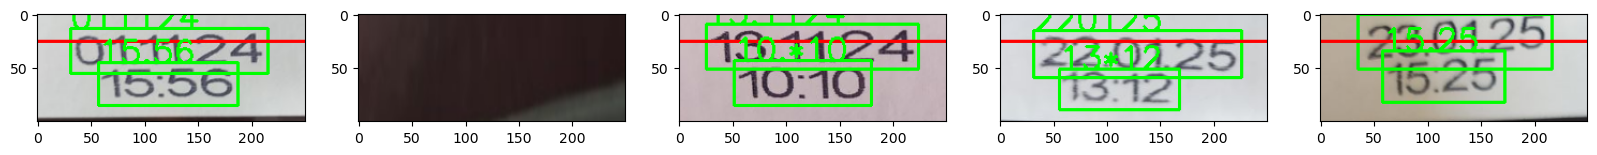

--------------------
IMAGE INDEX  30
Top Text: 08.08.24
Bottom Text: 14.44
--------------------
--------------------
IMAGE INDEX  31
Top Text: 13.11.24
Bottom Text: 10.10
--------------------
--------------------
IMAGE INDEX  32
Top Text: 29.12.24
Bottom Text: 15.16
--------------------
--------------------
IMAGE INDEX  33
Top Text: 
Bottom Text: 
--------------------
--------------------
IMAGE INDEX  34
Top Text: 12.12.24
Bottom Text: 10.20
--------------------


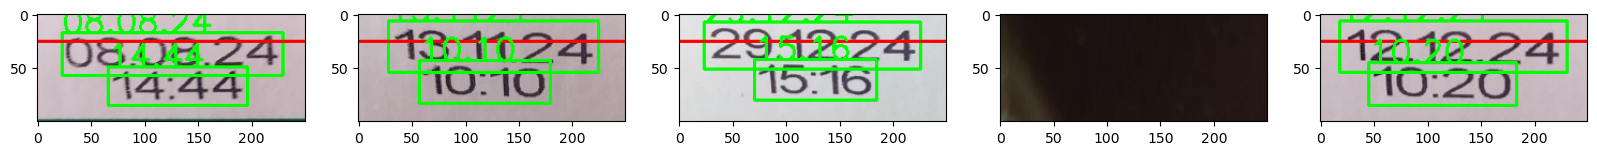

--------------------
IMAGE INDEX  35
Top Text: 13.03.24
Bottom Text: 19.18
--------------------
--------------------
IMAGE INDEX  36
Top Text: 10.08.24
Bottom Text: 14.52
--------------------
--------------------
IMAGE INDEX  37
Top Text: 22.02.24
Bottom Text: 09.56
--------------------
--------------------
IMAGE INDEX  38
Top Text: 10.03.24
Bottom Text: 09.31
--------------------
--------------------
IMAGE INDEX  39
Top Text: 08.06.24
Bottom Text: 14.04
--------------------


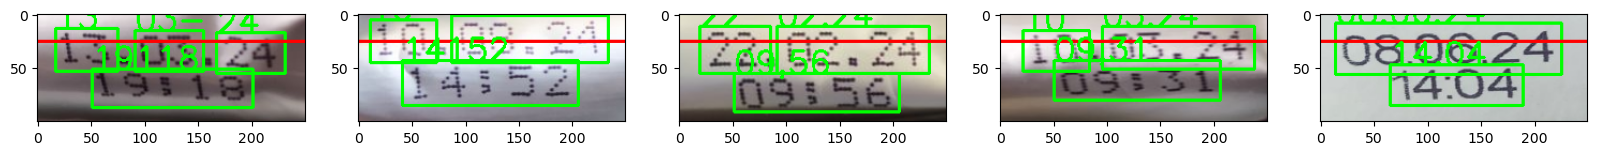

--------------------
IMAGE INDEX  40
Top Text: 20.07.24
Bottom Text: 10.07
--------------------
--------------------
IMAGE INDEX  41
Top Text: 08.08.24
Bottom Text: 13.25
--------------------


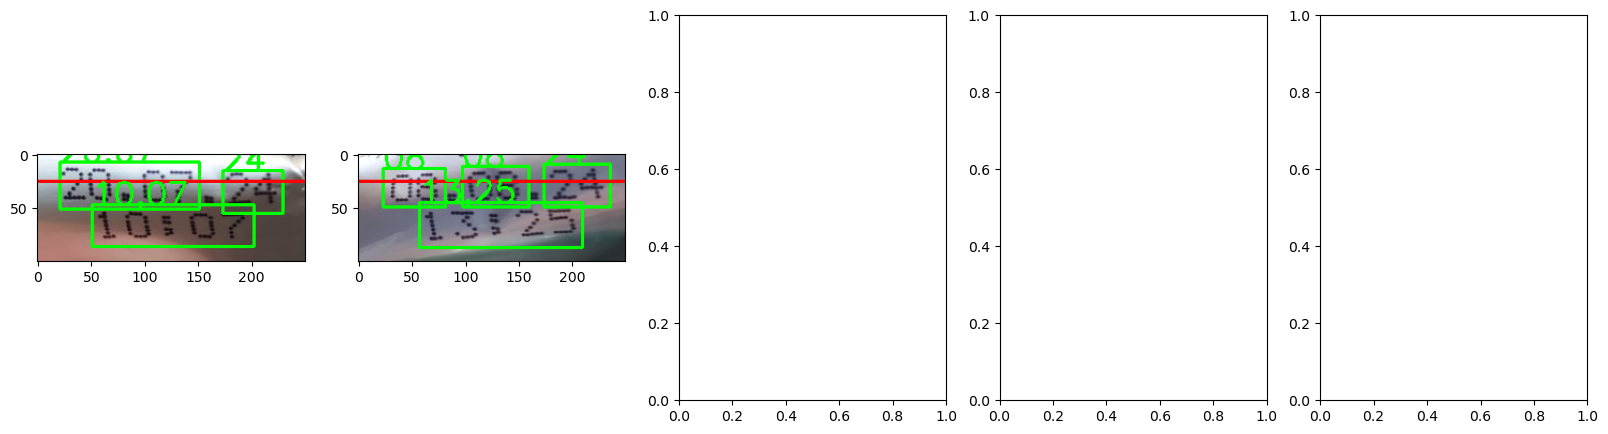

In [69]:
import re
cropped_images : list = localize_image()
print("CROPPED IMAGE => ",len(cropped_images))
reader = easyocr.Reader(['en'])

# show bounding box
count = 0
show_per_row = 5
top_bound = 25

def remove_special_character(text):
    return re.sub(r'[^a-zA-Z0-9]', '', text)

def give_punctuations(text):
    # give "." each 2 characters
    return ".".join([text[i:i+2] for i in range(0, len(text), 2)])

def remove_middle_character(text):
    # remove index 3 of text
    if len(text) < 5:
        return text
    return text[:2] + text[3:]

for i,image in enumerate(cropped_images):
    result = reader.readtext(image, text_threshold=0.6, width_ths=0.5, link_threshold=0.8)
    text_top = ""
    text_bottom = ""
    for (bbox, text, prob) in result:
        # Ensure bbox coordinates are tuples
        top_left = tuple(map(int, bbox[0]))  # Convert to (x, y)
        bottom_right = tuple(map(int, bbox[2]))  # Convert to (x, y)
        
        if top_left[1] < top_bound:
            text_top += text
        else:
            text_bottom += text
        
        # Draw line to separate top and bottom text
        cv2.line(image, (0, top_bound), (image.shape[1], top_bound), (255, 0, 0), 2)
        
        # Draw rectangle
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        
        # Add text
        cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
    
    print("-"*20)
    print("IMAGE INDEX ", i)
    print(f"Top Text: {give_punctuations( remove_special_character(text_top))}")
    print(f"Bottom Text: {give_punctuations(remove_middle_character(remove_special_character(text_bottom)))}")
    print("-"*20)
    if count % show_per_row == 0:
        fig, axs = plt.subplots(1, show_per_row, figsize=(20, 5))
    axs[count % show_per_row].imshow(image, cmap='gray')
    # axs[count % show_per_row].axis('off')
    count += 1
    if count % show_per_row == 0:
        plt.show()


# for (bbox, text, prob) in result:
#     (top_left, top_right, bottom_right, bottom_left) = bbox
#     cv2.rectangle(cropped_image, top_left, bottom_right, (0, 255, 0), 2)
#     cv2.putText(cropped_image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
  
# plt.imshow(cropped_image)
# plt.axis('off')
# plt.show()



In [34]:
for image in cropped_images:
  result = reader.readtext(image, detail=0)
  print(result)

['10.40']
[]
[]
[]
[]
[]
[]
['EMIGIC']
['24']
['[09.59']
[]
[]
['124']
['24']
['182424', '13.20']
['6,0924', '09.46']
['24', 'IUU']
['T1113']
['04,07.24', 'I0.Z0']
['2024']
['0', '24', 'IZZZ']
['214']
['}7.24', '2C']
['24']
['03.07', '2024']
['24', '15356']
[]
['24', 'IU:']
['Izah]', '25']
['Jgcci', '25', 'Io.C']
['24', '4.44']
['24']
['29', '14', '24', '576']
[]
['24', 'ZU']
[]
[]
['09,56']
[]
['24', '14.04']
[]
[]
